# Project #4 Artificial intelligance (Classification Models)
# (spring 2022)

    Amirmahdi Ansaripour

    Student ID: 810198358
    
    
Approach:
The goal is to analyze some famous classification models (KNN, tree, forest) on an input file.

Firstly, we do some preprocess on data such as : replacing NaN values, normalizing, etc.

After that, we divide the data into train and test parts which the ratio is highly importand
Lastly, we apply the models on train and test, measuring how great they are.


In [1046]:

import pandas as pds
import sys
from matplotlib import pyplot as plot
plot.rcParams["figure.figsize"] = (20 ,3)
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
pds.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import math


trainDataFrame = pds.read_csv("dataset.csv")

## Phase 0 (EDA and Visualization)

What we do here is :

1. Getting a general vision of the data

2. Showing percentage of NaN values in each column

3. Show density distribution of the mentioned percentages

In [1047]:
trainDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
artist_name         28506 non-null object
track_name          30000 non-null object
popularity          30000 non-null float64
acousticness        30000 non-null float64
danceability        30000 non-null float64
duration_ms         26990 non-null float64
energy              30000 non-null float64
instrumentalness    30000 non-null float64
key                 30000 non-null object
liveness            30000 non-null float64
loudness            30000 non-null float64
mode                30000 non-null object
speechiness         30000 non-null float64
tempo               27067 non-null float64
valence             30000 non-null float64
music_genre         30000 non-null object
dtypes: float64(11), object(5)
memory usage: 3.7+ MB


In [1048]:
trainDataFrame.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,30000.000000,30000.000000,30000.000000,2.699000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,27067.000000,30000.000000
mean,47.769533,0.359661,0.540929,2.466460e+05,0.556709,0.180807,0.183610,-10.079862,0.083861,117.559824,0.446563
std,14.512665,0.364182,0.181719,1.126005e+05,0.277856,0.329365,0.150733,6.953936,0.093366,30.719934,0.248745
min,0.000000,0.000001,0.059600,1.550900e+04,0.000792,0.000000,0.015700,-47.046000,0.022300,34.347000,0.000000
25%,39.000000,0.029600,0.423000,1.904930e+05,0.361000,0.000000,0.095800,-12.057250,0.035000,92.340000,0.243000
50%,49.000000,0.205000,0.553000,2.245600e+05,0.602000,0.000089,0.122000,-7.623000,0.045100,115.491000,0.435000
75%,57.000000,0.710000,0.671000,2.726670e+05,0.786000,0.125250,0.222000,-5.429750,0.080300,139.817500,0.639000
max,99.000000,0.996000,0.977000,3.195440e+06,0.998000,0.994000,0.996000,1.342000,0.941000,219.331000,0.985000


Percentages (greater than zero) of missed values in columns : 
artist_name     4.980000
duration_ms    10.033333
tempo           9.776667
dtype: float64


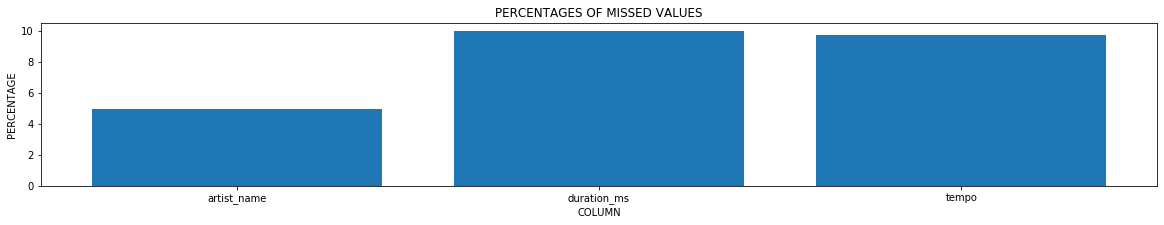

In [1049]:
def showPercentagesOfNaNs(trainDataFrame):
    missedNaNValues = trainDataFrame.isna().sum() * 100 / len(trainDataFrame)
    print("Percentages (greater than zero) of missed values in columns : ")
    print(missedNaNValues[missedNaNValues > 0])
    plotted = dict(missedNaNValues[missedNaNValues > 0])
    plot.bar(plotted.keys(), plotted.values())
    plot.xlabel('COLUMN')
    plot.ylabel('PERCENTAGE')
    plot.title('PERCENTAGES OF MISSED VALUES')
    plot.show()
    return

showPercentagesOfNaNs(trainDataFrame)


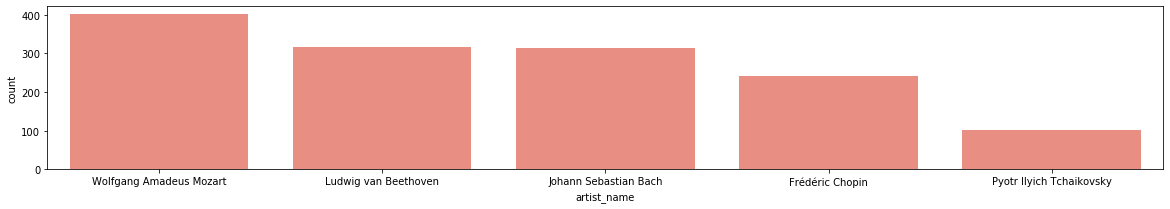

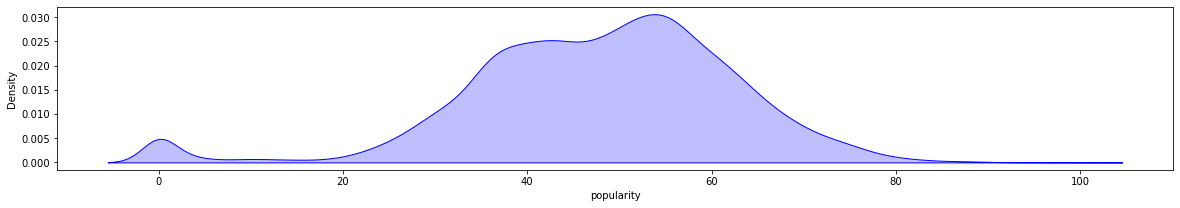

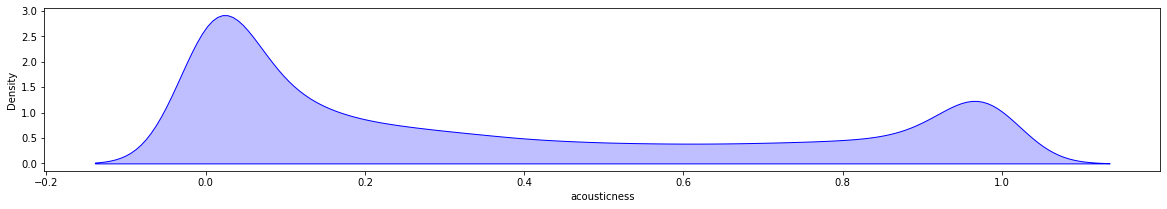

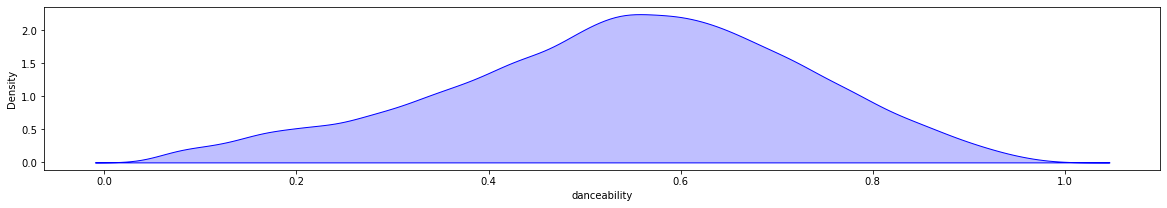

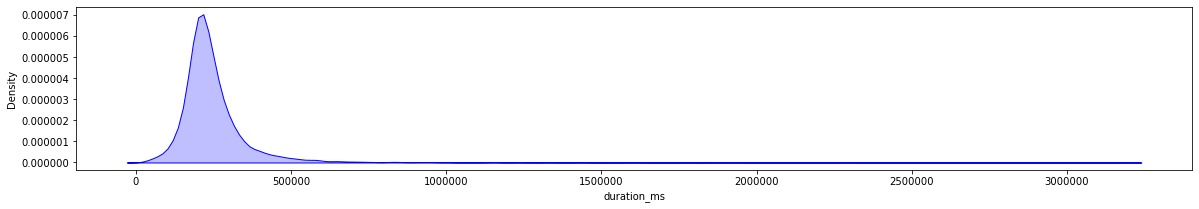

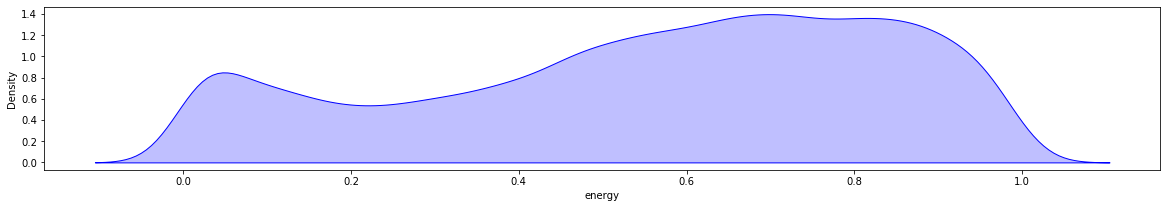

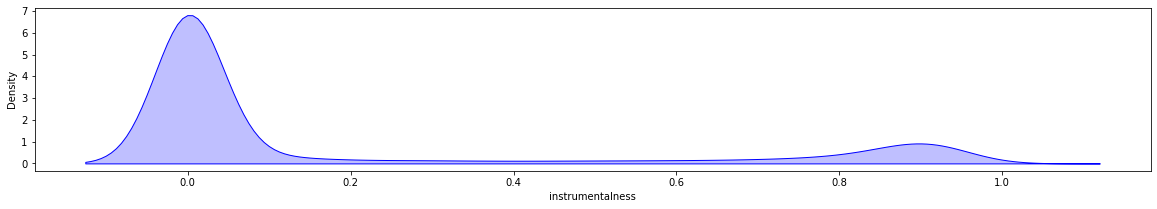

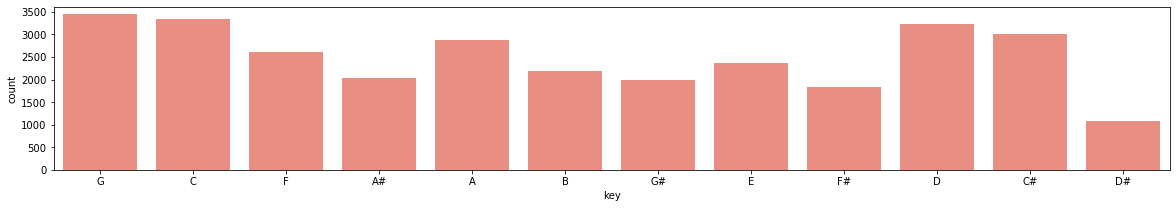

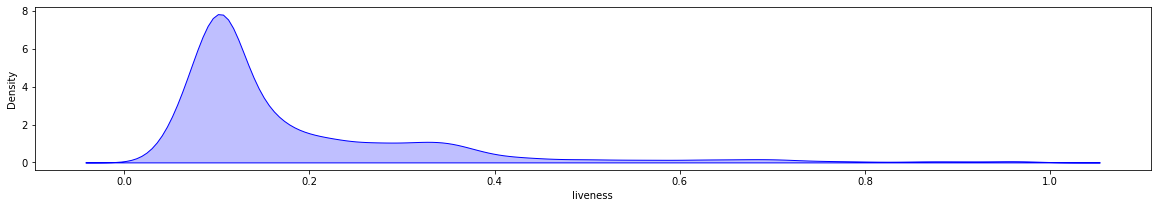

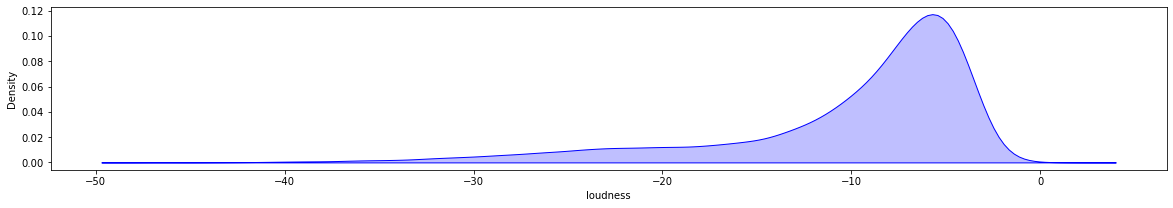

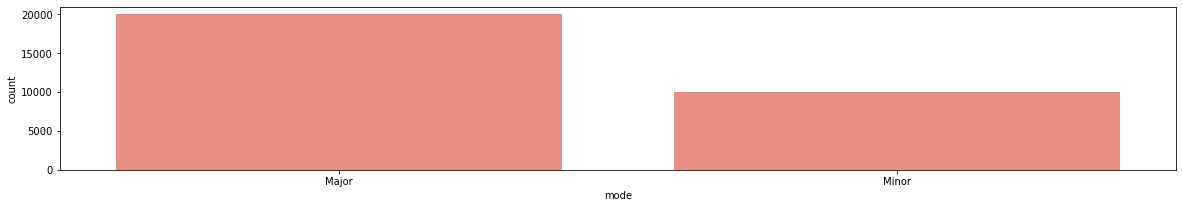

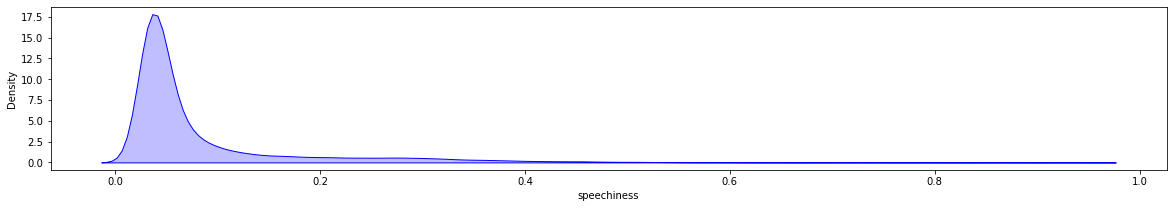

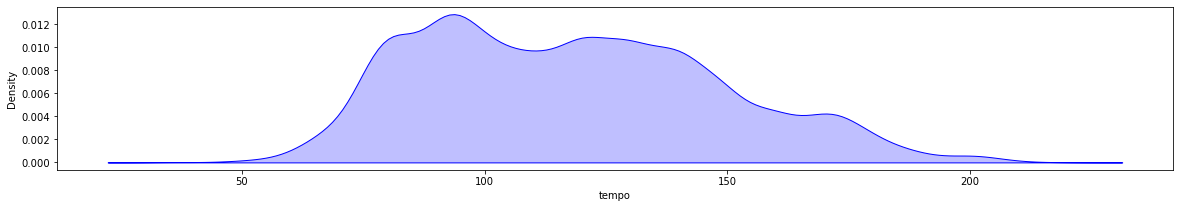

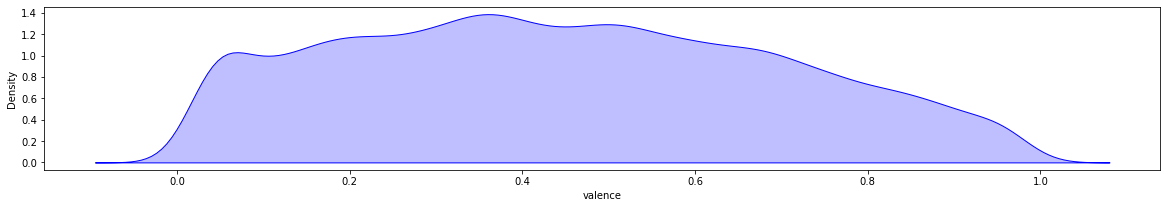

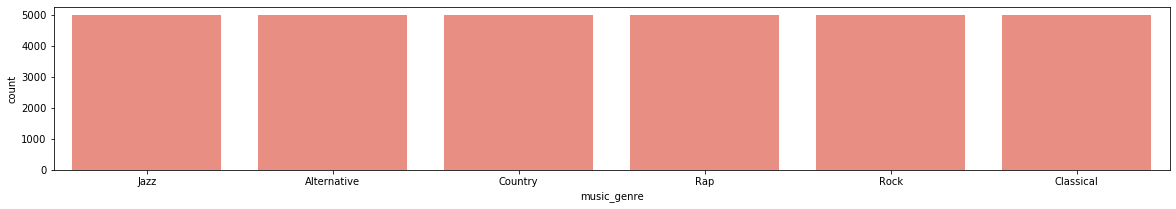

In [1050]:
def showDistributions(trainDataFrame):
    for i, column in enumerate(trainDataFrame.columns):
        if(column == "track_name"):
            continue
        elif(column == "artist_name"):
            sns.countplot(x = column, color = "salmon",
                          order=trainDataFrame[column].value_counts().iloc[:5].index,
                          data = trainDataFrame)
        else:
            plot.figure(i)
            if(trainDataFrame[column].dtype.name == "object"):
                sns.countplot( x = column, color = "salmon", data = trainDataFrame)
            else:
                sns.kdeplot(trainDataFrame[column], shade=True, color="b") 
    return

showDistributions(trainDataFrame)

None of the features have a clear normal distribution.

But generally looking, danceability's distribution is similar to normal

What's important is that music_genre has a unary distribution and the reason will be explained. 

## Phase 1 (Preprocessing) 

What we do here is generally making our dataset completely understandable for the model. It's done by: 

1. Omitting NaN values

2. Standardization and normalization

3. Working with categorical columns and change the way of representin them

4. Finding information gain for each variable

At the end of project, we apply all preprocessing methods to see which one better represents our model. Because each method has its own advanteges and disadvantages, we cant put a bad or good label on them.

Q1) Explain some different techniques of treating with NaN values and their cons and pros.

1. Omitting the whole column (or the rows intersecting with NaNs of the column) : Obviously we are losing some data in this method. The only case that this method can be useful is when the column contains alot of NaNs. 

2. Replacing with mean and mode of the column : Depending on the fact that categorical columns dont have mean, we use one of the metrics. But the point is that mean and mode are influenced by outliers, which are located far away from main data.


Q2) 

Normalization : 

The formula is :

    Column = (Column - minVal) / (maxVal - minVal)

Resulting in limitizing each column's values in the (-1, 1).

Standardization :

The formula is :
    
        Column = (Column - mean) / std
        
Resulting in that all variables will have normal distribution

In [1051]:
def oneHotMethod(trainDataFrame):
    temp = trainDataFrame.copy()
    categoricals = getCategoricalColumns(trainDataFrame)
    encoder = OneHotEncoder()
    onehottedMatrix = encoder.fit_transform(trainDataFrame[categoricals]).toarray()
#     print(onehot)
#     print(categoricals)
    encodedColumns = encoder.get_feature_names_out(categoricals)
#     print(encodedColumns)
    # print(encoded)
    for categorical in categoricals:
            del temp[categorical]
    
    return pds.DataFrame(onehottedMatrix, columns = encodedColumns)
    # print(categorical_df.head(10))

In [1052]:
def labelMethod(X, var, vector):
    X[var].replace(vector, inplace = True)
#     sns.countplot( x = var , color = "salmon", data = X)
    return X

def handleNaNs(string, trainDataFrame, column):
    if(string == "omit"):
        trainDataFrame.drop(columns = [column], axis = 1)
    elif(string == "mean"):
        trainDataFrame[column] = trainDataFrame[column].fillna(trainDataFrame[column].mean())
    elif(string == "mode"):
        trainDataFrame[column] = trainDataFrame[column].fillna(trainDataFrame[column].mode()[0])
    return

def applyNaNHandlingMethod(str1, str2, str3, trainDataFrame):
    handleNaNs(str1, trainDataFrame, "artist_name")
    handleNaNs(str2, trainDataFrame, "duration_ms")
    handleNaNs(str3, trainDataFrame, "tempo")
    return
    

[0.51153972 0.36040521 0.27819119 0.10376043 0.32727719 0.29480192
 0.02374524 0.02252318 0.34523587 0.03096012 0.21766735 0.09398294
 0.13507659]


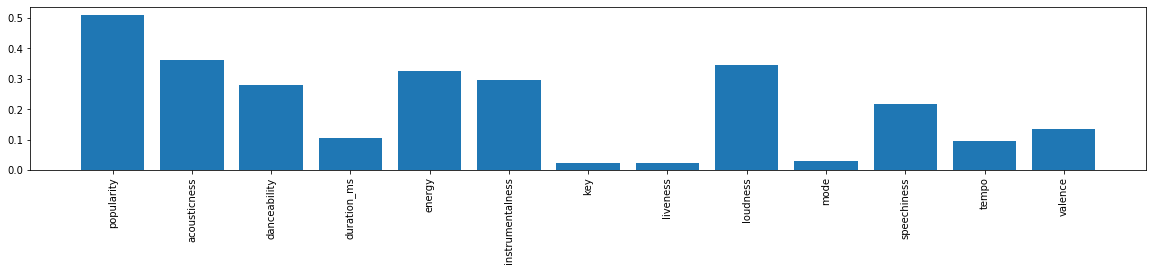

In [1053]:
def showIG(trainDataFrame):
    applyNaNHandlingMethod("mode", "mean", "mean", trainDataFrame)
    trainDataFrame = trainDataFrame.drop('artist_name', axis = 1)
    trainDataFrame = trainDataFrame.drop('track_name', axis = 1)
    X = trainDataFrame.copy()
    keyReplacements = {
        'A' : 1,
        'A#' : 2,
        'B' : 3,
        'B#' : 4,
        'C' : 5,
        'C#' : 6,
        'D' : 7,
        'D#' : 8,
        'E' : 9,
        'E#' : 10,
        'F' : 11,
        'F#' : 12,
        'G' : 13,
        'G#' : 14
    }
    X = labelMethod(X, "key", keyReplacements)
    modeReplacements = {
        'Major' : 1,
        'Minor' : 0
    }
    X = labelMethod(X, "mode", modeReplacements)
    varsToCalcIGfor = X.drop("music_genre", axis = 1)
    
    varsIG = mutual_info_classif(varsToCalcIGfor, X["music_genre"])
    print(varsIG)
    IG = pds.DataFrame(varsIG.reshape(1, -1), 
                       columns = varsToCalcIGfor.columns)
    
    plot.bar(IG.columns, varsIG)
    plot.xticks(rotation = 90)
    return

showIG(trainDataFrame)


Q3) Name two methods of analyzing categorical columns, in a way that they become understandable by the model.

Ordinal Encode : In this method, the categorical paremeter's value's are mapped to numbers.

It's disadvantage is that the numbers have a order showing their proirity but categoricals 

that are binary-valued(Yes / No) can't be represented by them.

OneHot Encode : In this method, we assing n bits to each parameter, based on how many values the parameter has. for example, a categorical parameter having 3 values, such as A, B, C, gets three bits. So some extra columns are added. Between the additional columns, only one of them gets 1 and others 0. for example an key with value = B is shown by 010.

Although it consumes more space, compared to previous one, but it doesn't have the problem of proiritizaztion.

In [1054]:
def getNumericalColumns(trainDataFrame):
        return list(trainDataFrame._get_numeric_data())
def getCategoricalColumns(trainDataFrame):
        res = list(trainDataFrame.select_dtypes(include=['object']))
        return res


Q4) We can add a column showing the singers' frequent music genre. To do that, the mode of each singer's songs genre is required. 

Q5) Removing variables having low information gain is wise, since calculations become less complicated. But we should be cautios about the accuracy and don't omit major columns.

In [1055]:
def normalize(trainDataFrame):
    numericals = getNumericalColumns(trainDataFrame)
    for column in numericals:
        max_value = trainDataFrame[column].max()
        min_value = trainDataFrame[column].min()
        trainDataFrame[column] = (trainDataFrame[column] - min_value) / (max_value - min_value)

    for col in numericals:
        for element in trainDataFrame[col]:
            if(element > 1 or element < -1):
                print("error")
    
    return trainDataFrame

def standardize(trainDataFrame):
    numericals = getNumericalColumns(trainDataFrame)
    for column in numericals:
        mean = trainDataFrame.loc[:, column].mean()
        stdr = trainDataFrame.loc[:, column].std()
        trainDataFrame.loc[:, column] = (trainDataFrame.loc[:, column] - mean) / stdr 
    return trainDataFrame

# standardize(trainDataFrame)


### Phase 2 (‫‪Model‬‬ ‫‪Training,‬‬ ‫‪Evaluation‬‬ ‫‪and‬‬ ‫‪Hyper‬‬ ‫‪Parameter‬‬ ‫‪Tuning‬‬)

Q6) Test percentage is one of the most important parameters in the learning. If it gets abnormaly high, overfitting occurs. On the opposite, learning won't be accurate enough. 

The model is trained with a series of test ratios at the end. It's wise that train covers the major part of dataset.

The next point is that shuffling the train and test inputs enhances our learning. The reason is that sometimes the dataset is sorted or arranged in a specific way, for example, price or date, etc. It's clear that we don't wan't any pre-learning in preprocessing phase.

Another important point is that, both train and test parts should contain equal ratis of each class. Suppose the train's samples are mostly of class A. The model will blindly predicts class A for test samples. 

In [1056]:

def randomlyDivide(trainDataFrame, label, testSize):
        
    trainandTest = trainDataFrame.iloc[:,:-1]
    
    X_train, X_test, y_train, y_test = train_test_split(trainandTest, label, 
   stratify = LabelEncoder().fit_transform(label), 
    test_size = testSize, random_state=0)
    
    return X_train, X_test, y_train, y_test 

def regularlyDivide(trainDataFrame, label, testSize):
    testColumnSize = int(len(trainDataFrame) * testSize)
    trainColumnSize = int(len(trainDataFrame) - testColumnSize)
    X_train = trainDataFrame.iloc[:trainColumnSize,:]
    y_train = label.iloc[:trainColumnSize]
    X_test = trainDataFrame.iloc[testColumnSize:,:]
    y_test = label.iloc[testColumnSize:]
    return X_train, X_test, y_train, y_test


In [1057]:
def preprocess(trainDataFrame, testSize, str1, str2, str3, standard, norm, oneHot, randomDivide, 
              omitLowIG):
    applyNaNHandlingMethod(str1, str2, str3, trainDataFrame)
    
    trainDataFrame = trainDataFrame.drop('artist_name', axis = 1)
    trainDataFrame = trainDataFrame.drop('track_name', axis = 1)
    
    numericalDataFrame = trainDataFrame[getNumericalColumns(trainDataFrame)]
    categoricalDataFrame = trainDataFrame[getCategoricalColumns(trainDataFrame)]

    if(omitLowIG):
            trainDataFrame = trainDataFrame.drop('liveness', axis = 1)
            trainDataFrame = trainDataFrame.drop('key', axis = 1)
            trainDataFrame = trainDataFrame.drop('duration_ms', axis = 1)
            trainDataFrame = trainDataFrame.drop('tempo', axis = 1)
    
    if(standard):
        numericalDataFrame = standardize(numericalDataFrame)
    if(norm):
        numericalDataFrame = normalize(numericalDataFrame)
    if(oneHot):
        categoricalDataFrame = oneHotMethod(categoricalDataFrame)

    preproccessedDF = pds.concat([numericalDataFrame, categoricalDataFrame], axis = 1)
    preproccessedDF.to_csv('result.csv')
    label = trainDataFrame["music_genre"]
    
    if(randomDivide):
        return randomlyDivide(preproccessedDF, label, testSize)
    else:
        return regularlyDivide(preproccessedDF, label, testSize)
# dataAnalysis(trainDataFrame, 0.4, "mode", "mean", "mean", False, False, True, False)


In [1058]:
def printScores(trainPreds, testPreds, parameter, paramName):
    y1 = trainPreds
    y2 = testPreds
    plot.plot(parameter, y1, color='r', label='Train')
    plot.scatter(parameter, y1)
    plot.plot(parameter, y2, color='g', label='Test')
    plot.scatter(parameter, y2)
    plot.xlabel(paramName)
    plot.ylabel("Accuracy")
    plot.title("Accuracy of Model")
    plot.legend()
    xmax = parameter[np.argmax(y2)]
    ymax = max(y2)
    plot.show()
#     max_y = max(y2)  
#     max_x = parameter[y2.argmax()]
    return

In [1059]:
def printMetrics(model, X_train, X_test, y_train, y_test):
    print("Metrics on train ")
    model.fit(X_train, y_train)
    print(classification_report(y_true = y_train, 
         y_pred = model.predict(X_train)))
    print("Metrics on test ")
    model.fit(X_test, y_test)
    print(classification_report(y_true = y_test, 
         y_pred = model.predict(X_test)))
    print("Accuracy on Train : " + str(model.score(X_train, y_train)))
    print("Accuracy on Test : " + str(model.score(X_test, y_test)))
    
    return

In [1060]:
def handleKNN(train, X_train, X_test, y_train, y_test, K_neighbors):
    trainPreds = []
    testPreds = []
    for size in K_neighbors:
        knn = KNeighborsClassifier(n_neighbors = size)
        knn.fit(X_train, y_train)
        trainPreds.append(knn.score(X_train, y_train))
        testPreds.append(knn.score(X_test, y_test))
    printScores(trainPreds, testPreds, K_neighbors, "Number of Neighbors")
    printMetrics(KNeighborsClassifier(n_neighbors = 40)
                 , X_train, X_test, y_train, y_test)
    return

In [1061]:
def handleDecisionTree(train, X_train, X_test, y_train, y_test, maxDepth, minSamplesLeaf):
    trainPreds = []
    testPreds = []
    inputs = []
    for depth in maxDepth:
        for leaf in minSamplesLeaf:
            tree = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf)
            tree.fit(X_train, y_train)
            trainPreds.append(tree.score(X_train, y_train))
            testPreds.append(tree.score(X_test, y_test))
            inputs.append(str((depth, leaf)))
        
    printScores(trainPreds, testPreds, inputs, "(Depth, Leaf)")
    printMetrics(DecisionTreeClassifier(max_depth = 4 ,min_samples_leaf = 1),
                 X_train, X_test, y_train, y_test)
    return

In [1062]:
def printCofusionMatrix(model, y_test, X_test):
    model.fit(X_test, y_test)
    print(confusion_matrix(y_true=y_test, y_pred=model.predict(X_test)))
    return

def handleForest(train, X_train, X_test, y_train, y_test, maxDepth, minSamplesLeaf, estSize):
        trainPreds = []
        testPreds = []
        inputs = []
        for estNum in estSize:
            for depth in maxDepth:
                for leaf in minSamplesLeaf:
                    forest = RandomForestClassifier(n_estimators = estNum,
                                  max_depth = depth, min_samples_leaf = leaf)
                    forest.fit(X_train, y_train)
                    trainPreds.append(forest.score(X_train, y_train))
                    testPreds.append(forest.score(X_test, y_test))
                    inputs.append(str((estNum, depth, leaf)))

        printScores(trainPreds, testPreds, inputs, "(Num of Estimator, Depth, Leaf)")
        printMetrics(RandomForestClassifier(n_estimators = 30,
                                  max_depth = 4, min_samples_leaf = 1),
                     X_train, X_test, y_train, y_test)
        printCofusionMatrix(RandomForestClassifier(n_estimators = 30,
                                  max_depth = 4, min_samples_leaf = 1),
                            y_test, X_test)
        return


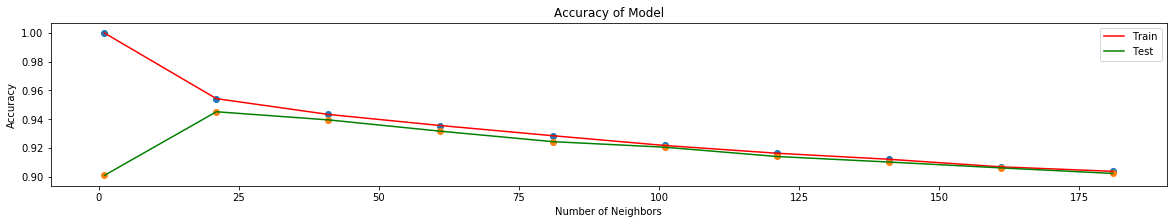

Metrics on train 
              precision    recall  f1-score   support

 Alternative       0.97      0.94      0.95      2500
   Classical       0.97      0.95      0.96      2500
     Country       0.97      0.97      0.97      2500
        Jazz       0.95      0.92      0.94      2500
         Rap       0.93      0.94      0.94      2500
        Rock       0.88      0.95      0.91      2500

    accuracy                           0.94     15000
   macro avg       0.95      0.94      0.94     15000
weighted avg       0.95      0.94      0.94     15000

Metrics on test 
              precision    recall  f1-score   support

 Alternative       0.98      0.94      0.96      2500
   Classical       0.97      0.95      0.96      2500
     Country       0.97      0.97      0.97      2500
        Jazz       0.95      0.91      0.93      2500
         Rap       0.93      0.95      0.94      2500
        Rock       0.88      0.95      0.91      2500

    accuracy                           0.9

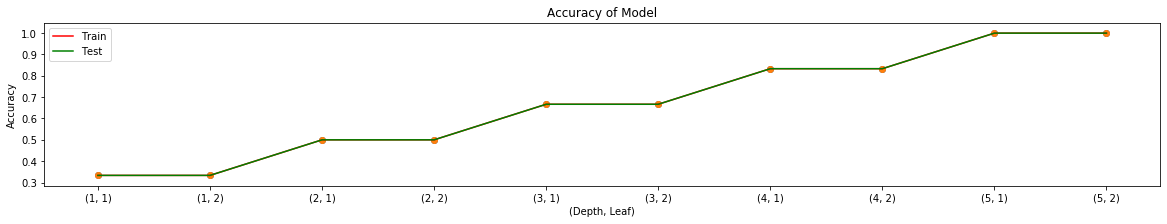

Metrics on train 


/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Alternative       1.00      1.00      1.00      2500
   Classical       0.50      1.00      0.67      2500
     Country       1.00      1.00      1.00      2500
        Jazz       1.00      1.00      1.00      2500
         Rap       1.00      1.00      1.00      2500
        Rock       0.00      0.00      0.00      2500

    accuracy                           0.83     15000
   macro avg       0.75      0.83      0.78     15000
weighted avg       0.75      0.83      0.78     15000

Metrics on test 


/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amirmahdi/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Alternative       0.50      1.00      0.67      2500
   Classical       1.00      1.00      1.00      2500
     Country       1.00      1.00      1.00      2500
        Jazz       1.00      1.00      1.00      2500
         Rap       1.00      1.00      1.00      2500
        Rock       0.00      0.00      0.00      2500

    accuracy                           0.83     15000
   macro avg       0.75      0.83      0.78     15000
weighted avg       0.75      0.83      0.78     15000

Accuracy on Train : 0.8333333333333334
Accuracy on Test : 0.8333333333333334


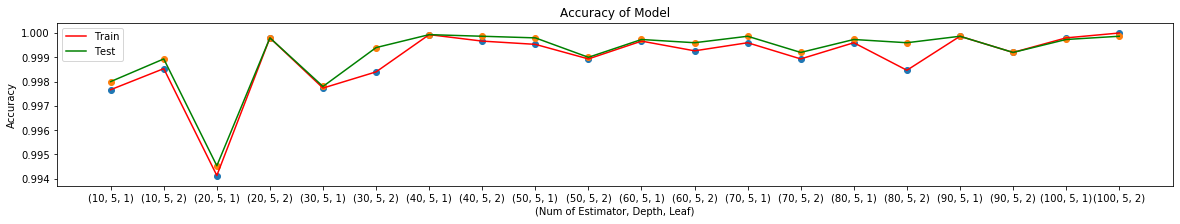

Metrics on train 
              precision    recall  f1-score   support

 Alternative       1.00      1.00      1.00      2500
   Classical       0.99      1.00      1.00      2500
     Country       1.00      1.00      1.00      2500
        Jazz       1.00      1.00      1.00      2500
         Rap       1.00      1.00      1.00      2500
        Rock       1.00      0.99      0.99      2500

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

Metrics on test 
              precision    recall  f1-score   support

 Alternative       1.00      1.00      1.00      2500
   Classical       1.00      1.00      1.00      2500
     Country       0.99      1.00      1.00      2500
        Jazz       0.99      1.00      0.99      2500
         Rap       0.99      1.00      1.00      2500
        Rock       1.00      0.97      0.98      2500

    accuracy                           0.9

In [1063]:
def testDifferentModels():
    train = pds.read_csv("dataset.csv")
    X_train, X_test, y_train, y_test = preprocess(train, 0.5, "mode", "mean", "mean",
                                                  standard = True, norm = False, 
                                                 oneHot = True, randomDivide = True, 
                                                  omitLowIG = True)
    handleKNN(train, X_train, X_test, y_train, y_test, range(1, 200, 20))
    handleDecisionTree(train, X_train, X_test, y_train, y_test, range(1, 6), range(1, 3))
    handleForest(train, X_train, X_test, y_train, y_test, [5], [1, 2], range(10, 101, 10))
    return
testDifferentModels()

Q1) 

Overfitting : When the module predicts the test abnormally true, in other words, it memorizes the train, we should be aware of overfitting. When a module has overfitting, it doesn't have the ability to generalize and accept new samples.

Underfitting : It's worse than overfitting. In overfitting, at least the train part is predicted correctly, but when a module underfits, it lacks in both train and test prediction accuracy.

The plots indicate that our models do not over or underfit. Because the test prediction, which is the ultimate goal, remains high in both.


Q2)

Accuracy : the typical division of total truely predicted over all samples.

Precision : Between the samples which we predicted as class A, what percentage of them is truly of class A?

       Precision = TP / TP + FP

Recall : Between the samples that are truly of class A, what percentage of them are predicted by our model

        Recall = TP / TP + FN
        

F1-score : Something that is influenced by both recall and precision.

        F1-score = 2 * precision * recall / (precision + recall)

In [1064]:
def analyzeDifferentPreprocessing(model):
    train = pds.read_csv("dataset.csv")
#     testSizes = [0.01 , 0.1, 0.4, 0.7, 0.9, 0.99]
    testSizes = [0.01, 0.6]
    durationandTempoStatus = ["mode", "mean"]
    standard = [True, False]
    randomDivide = [True, False]    
    doOmit = [True, False]
    oneHot = True
    res = []
    i = 0
    for testSize in testSizes:
        for division in randomDivide:
            for std in standard:
                for durationandTempo in durationandTempoStatus:
                    for omit in doOmit:
                            X_train, X_test, y_train, y_test = preprocess(
                                train, testSize, "mode", durationandTempo, durationandTempo,
                                              std, not(std), 
                                             True, division, omit)

                            model.fit(X_train, y_train)
                            accOnTrain = model.score(X_train, y_train)
                            accOnTest = model.score(X_test, y_test)
                            row = {"model" : model,
                                  "test size" : testSize, "artist" : "mode", 
                                  "duration" : durationandTempo,"tempo" : durationandTempo, 
                                  "standard" : std, "norm" : not(std), "oneHot" : True,
                                 "randomDiv" : division, "Omit" : omit, "test acc" : accOnTest, 
                                  "train acc" : accOnTrain, 
                                  }
                            res.append(row)
#                             i = i + 1
#                             print(i)
    results = pds.DataFrame.from_records(res)
    return results


df = analyzeDifferentPreprocessing(KNeighborsClassifier(n_neighbors = 21))
df

,model,test size,artist,duration,tempo,standard,norm,oneHot,randomDiv,Omit,test acc,train acc
0,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,True,False,True,True,True,0.973333,0.964276
1,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,True,False,True,True,False,0.973333,0.964276
2,KNeighborsClassifier(n_neighbors=21),0.01,mode,mean,mean,True,False,True,True,True,0.973333,0.964276
3,KNeighborsClassifier(n_neighbors=21),0.01,mode,mean,mean,True,False,True,True,False,0.973333,0.964276
4,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,False,True,True,True,True,0.996667,0.999192
5,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,False,True,True,True,False,0.996667,0.999192
6,KNeighborsClassifier(n_neighbors=21),0.01,mode,mean,mean,False,True,True,True,True,0.996667,0.999192
7,KNeighborsClassifier(n_neighbors=21),0.01,mode,mean,mean,False,True,True,True,False,0.996667,0.999192
8,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,True,False,True,False,True,0.981246,0.981044
9,KNeighborsClassifier(n_neighbors=21),0.01,mode,mode,mode,True,False,True,False,False,0.981246,0.981044


### Conclusion

We've learnt how to use sklearn libraries to apply different classification models on a dataset. The basic conceptions in Machine learning were also mentioned in the article, and an introduction to famous modules and their hyperparameters.

At last, evaluation metrics were explained and how the assess the learning, each in its own way.

### Refrences

1) https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4

2) https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d

3) https://towardsdatascience.com/categorical-encoding-techniques-93ebd18e1f24